# Yagi antenna for 146 MHz
In this notebook, a practical Yagi antenna for the $2\,m$ amateur radio band ($144-148\,\mathrm{MHz}$) is modeled using the thin-wire MoM implementation.
 - Input impedance versus frequency
 - Far-field radiation pattern

In [1]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/PostProcessing.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [2]:
ε = 8.854e-12      # Vacuum permittivity [F/m]
μ = 4e-7 * π       # Vacuum permeability [H/m]

c = 1 / √(μ * ε)   # Speed of light in vacuum [m/s]
η = √(μ / ε)       # Impedance of vacuum [Ω]

376.73430918211017

# Generate mesh
The geometry is taken from "The Method of Moments in Electromagnetics", Gibson, 2022, page 115. It consists of a reflector, a driven element, and 7 director elements, each consisting of with 25 segments. The diameter of all elements is $6.35\,\mathrm{mm}$.

The antenna is aligned along the $x$-axis, with the highest gain in the $+x$ direction.

In [3]:
Nel = 25
l = [1038, 955, 956, 932, 916, 906, 897, 891, 887] * 1e-3
x = [0, 312, 447, 699, 1050, 1482, 1986, 2553, 3168] * 1e-3
a = 6.35e-3 / 2

nodes = [0 0 0]
edges = [[]]

for (len, pos) ∈ zip(l, x)
    n, e = mesh_segment([pos -len/2 0], [pos len/2 0], Nel, size(nodes, 1))
    nodes = vcat(nodes, n)
    edges = vcat(edges, e)
end

nodes = nodes[2:end, :]
edges = edges[2:end]

end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.0 -0.519 0.0; 0.0 -0.47748 0.0; … ; 3.168 0.40801999999999994 0.0; 3.168 0.4435 0.0], Vector{Any}[[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [224, 225], [225, 226], [226, 227], [227, 228], [228, 229], [229, 230], [230, 231], [231, 232], [232, 233], [233, 234]], [1, 26, 27, 52, 53, 78, 79, 104, 105, 130, 131, 156, 157, 182, 183, 208, 209, 234], [0.0 -1.0 0.0; 0.0 -1.0 0.0; … ; 0.0 -1.0 0.0; 0.0 -1.0 0.0], 0.003175)

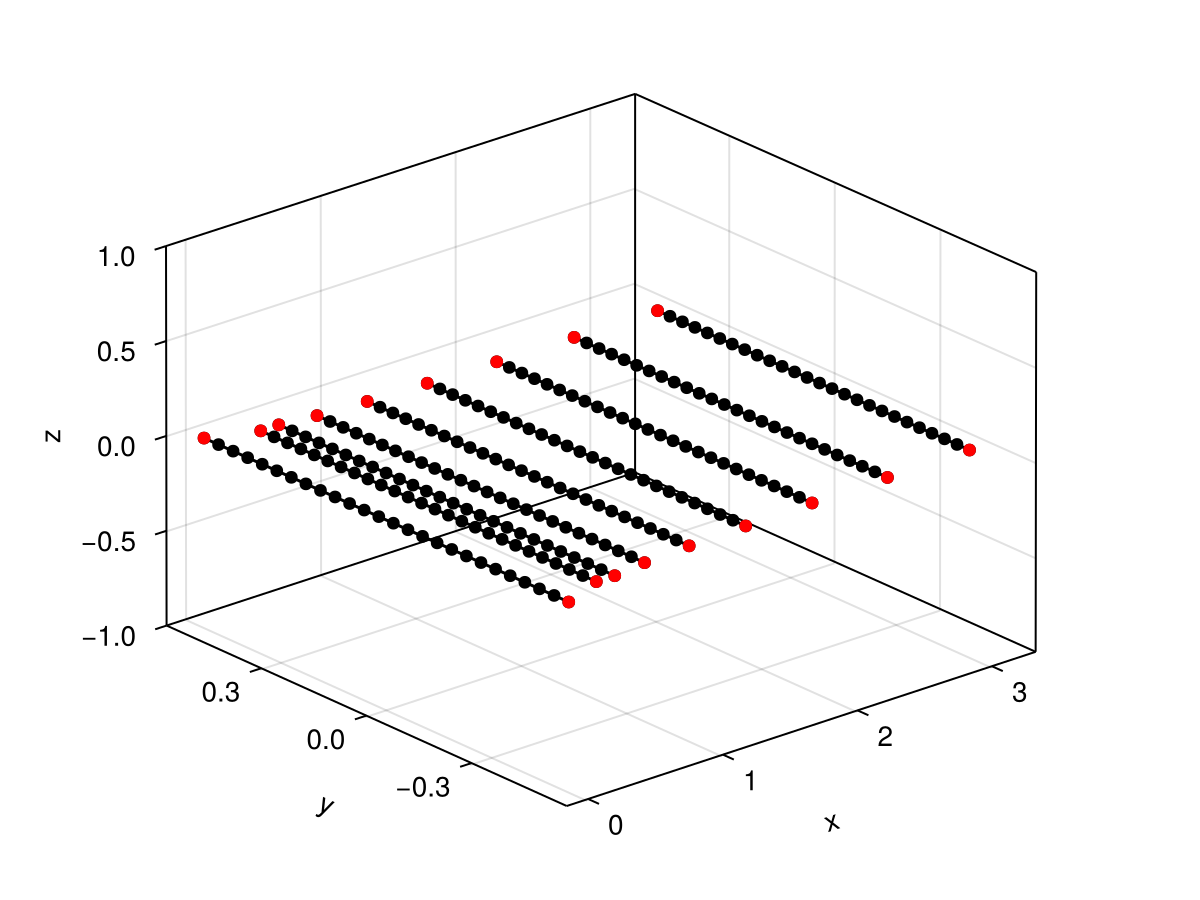

In [4]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources
The driven element has a delta-gap voltage source in the middle.

In [5]:
# Mid-point feed
Vin = 1
idx_mid = Integer(Nel + ceil(Nel / 2))
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 38)

# Frequency sweep
Next, we can solve the current distribution for a range of frequencies and plot the input impedance vs frequency. The feedpoint resistance ranges from $18$ to $33\,\Omega$. There is also a capacitive reactance, which is common for Yagi antennas.

In [12]:
frequencies = range(144e6, 148e6, 20)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    # Calculate input impedance
    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

─────────────────────────────────────────────────────────────────────────────
                                    Time                    Allocations      
                           ───────────────────────   ────────────────────────
     Tot / % measured:          13.2s /  99.2%           10.3GiB / 100.0%    

Section            ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────────
frequency sweep         1    13.1s  100.0%   13.1s   10.3GiB  100.0%  10.3GiB
  assembly             20    13.0s   99.7%   652ms   10.3GiB   99.8%   527MiB
    outer loop         20    13.0s   99.6%   651ms   10.3GiB   99.7%   526MiB
      inner loop    4.50k    13.0s   99.2%  2.88ms   10.3GiB   99.6%  2.33MiB
        element     1.01M    10.0s   76.4%  9.86μs   9.00GiB   87.4%  9.33KiB
      source        4.50k   38.4ms    0.3%  8.54μs   10.4MiB    0.1%  2.38KiB
  solve                20   38.9ms    0.3%  1.94ms   16.8MiB   

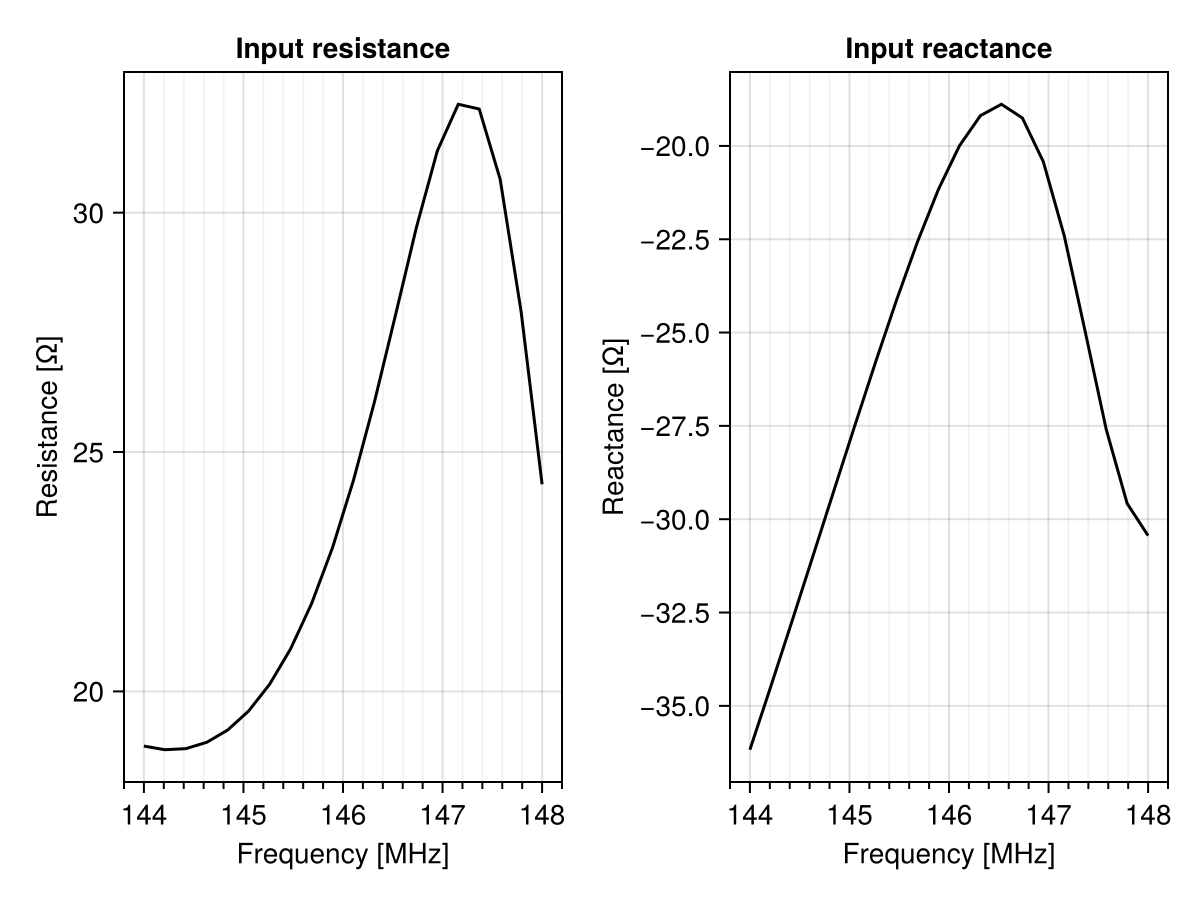

In [7]:
fig = Figure()
ax1 = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="Resistance [Ω]", title="Input resistance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

lines!(ax1, frequencies * 1e-6, real.(Zin), color=:black)

ax2 = Axis(
    fig[1, 2],
    xlabel="Frequency [MHz]", ylabel="Reactance [Ω]", title="Input reactance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

lines!(ax2, frequencies * 1e-6, imag.(Zin), color=:black)

fig

# Far-field radiation pattern
The far-field radiation pattern is calculated using the far-field approximation at a distance of $100 \lambda$ from the antenna.# Far-field radiation pattern

In [8]:
f = 146e6

# Solve currents
Z, V = assemble_global(msh, src, f, μ, ε)
Isol = Z \ V

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

reset_timer!()

# Calculate far field E-field
R = 100 * (c / f)       # Radius of evaluation points
N = 100                 # Number of evaluation points
θs = range(0, 2π, N)    # Evaluation angles

coords_xy = zeros(N, 3)
coords_xz = zeros(N, 3)
for (i, θ) ∈ enumerate(θs)
    coords_xy[i, :] = [(R * cos(θ)) (R * sin(θ)) 0]
    coords_xz[i, :] = [(R * cos(θ)) 0 (R * sin(θ))]
end

@timeit "FarField - xy" Exy = CalcFarField(msh, Isol, coords_xy, f, μ, ε);
@timeit "FarField - xz" Exz = CalcFarField(msh, Isol, coords_xz, f, μ, ε);

Pavg = Vin^2 / real(Zin) / (4π * R^2) # Power density of isotropic radiator

Pxy = norm.(eachrow(Exy)) .^ 2 / η
Pxz = norm.(eachrow(Exz)) .^ 2 / η

print_timer()

────────────────────────────────────────────────────────────────────────────────
                                       Time                    Allocations      
                              ───────────────────────   ────────────────────────
      Tot / % measured:            2.60s /  81.7%            526MiB /  90.3%    

Section               ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────
FarField - xy              1    1.96s   92.5%   1.96s    411MiB   86.7%   411MiB
  evaluation loop          1    1.21s   57.2%   1.21s    296MiB   62.4%   296MiB
    loop over edges      100    1.21s   57.1%  12.1ms    295MiB   62.2%  2.95MiB
FarField - xz              1    160ms    7.5%   160ms   63.2MiB   13.3%  63.2MiB
  evaluation loop          1    160ms    7.5%   160ms   63.2MiB   13.3%  63.2MiB
    loop over edges      100    160ms    7.5%  1.60ms   62.1MiB   13.1%   636KiB
───────────────────────────

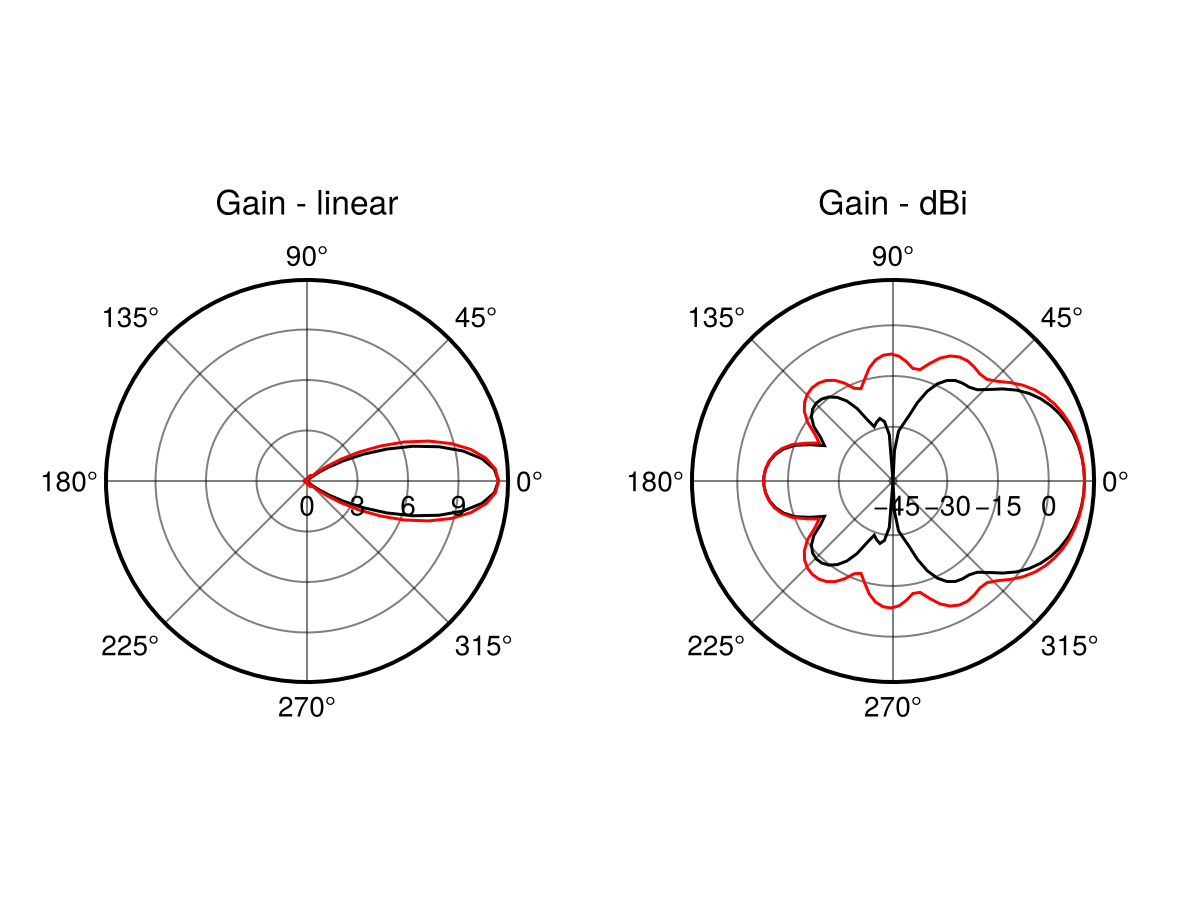

In [9]:
fig = Figure()

ax = PolarAxis(fig[1, 1], title="Gain - linear")
lines!(ax, θs, Pxy / Pavg, color=:black)
lines!(ax, θs, Pxz / Pavg, color=:red)

ax = PolarAxis(fig[1, 2], title="Gain - dBi")
lines!(ax, θs, 10 * log10.(Pxy / Pavg), color=:black)
lines!(ax, θs, 10 * log10.(Pxz / Pavg), color=:red)

fig

The calculated peak gain corresponds quite well to that given by Gibson.

In [10]:
Gain = 10 * log10(maximum(Pxy / Pavg)) # Gain in dBi
Gideal = 10; # Reference gain in dBi

err = (Gain - Gideal) / Gideal * 100

println("Error w.r.t Gibson: ", err, " %")

Error w.r.t Gibson: 5.595574695481993 %


The front-back ratio also matches well with the pattern presented by Gibson.

In [11]:
Efront = CalcFarField(msh, Isol, [100 0 0], f, μ, ε);
Eback = CalcFarField(msh, Isol, [-100 0 0], f, μ, ε);

Pfront = norm(Efront)^2 / η
Pback = norm(Eback)^2 / η

# Calculate the front-to-back ratio in dB
# Result from Gibson: ~18.3 dB
Rfb = 10 * log10(Pfront / Pback)

18.35983860084835